In [1]:
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt 
from thermal.derived_fields import Variable_at_ELA
from thermal.utils import calc_Temp


plt.rcParams['text.usetex'] = True

def func_of_year(t, z=2193): 
    z_ref=2193; T_ma  = -9.02; alpha = 10.8; T_p   = 196 ; dTdz  = 6.5e-3;
    
    T = T_ma + alpha*np.cos(2.0*np.pi*(t-T_p/365)) + dTdz*(z_ref-z) 
    
    return np.where(T > 0, 0, T)

def convert2temp(ds): 
    f = xr.apply_ufunc(calc_Temp, # first the function
                       ds, 1.0, # now arguments
                       input_core_dims=[["t"], []], # list with one entry per arg
                       output_core_dims=[["t"]],  # dimensions allowed to change size. Must be set!
                      )
    return f - 273.15

def get_T_at_ELA(ds): 
    
    H_at_ELA = Variable_at_ELA(ds, 'surface_enthalpy')
    
    return convert2temp(H_at_ELA)

def get_timestep(ds): 
    
    # the difference of the sign will tell us where the mass balance crosses zero
    dt = xr.apply_ufunc(np.diff, 
                        ds.t, 
                        kwargs={"axis": -1, "prepend" : 0},
                        dask="allowed")
    
    return dt

In [3]:
src_fp = '../result/crmpt12/gridded/{}_8year_2year_cycles.zarr'
src_fp = '../result/crmpt12/gridded/16year_2a_surge_6a_quies_{}.zarr'

Backward Range = 0.9581
Centered Range = 0.0256
Forward Range = 0.9839


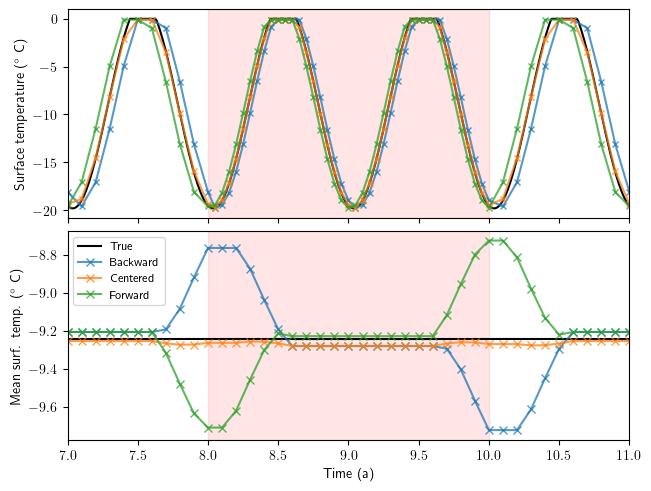

In [9]:
fig, ax = plt.subplots(2,1, sharex=True, constrained_layout=True)

difference = ['Backward', 
              'Centered', 
              'Forward', 
              # 'Centered_Fixed?',
              # 'Centered_PhaseUnshift'
             ]

t_true = np.linspace(0, 16, 1600)

# z_ref = float(src.Z.isel(coord_2=-1, coord_1=175).mean('t'))

ax[0].plot(t_true, func_of_year(t_true), c='k')
#        
    
ax[1].plot(t_true, np.ones_like(t_true)*func_of_year(t_true).mean(), label='True', c='k')

for diff in difference: 
    src = xr.open_zarr(src_fp.format(diff)).compute()
    
    T_at_ELA = get_T_at_ELA(src)
    # T_at_ELA = convert2temp(src.surface_enthalpy.isel(coord_1=175))
    
    ax[0].plot(T_at_ELA.t, T_at_ELA, alpha=0.75, marker='x', markersize=5.0)
    
    # if diff == 'Centered': 
    interp = src.interp(t=np.linspace(0.1,16,160), method='quadratic')

    T_at_ELA_interp = get_T_at_ELA(interp).rolling(t=10,center=True).mean('t')
    # T_at_ELA_interp = convert2temp(interp.surface_enthalpy.isel(coord_1=175)).rolling(t=10,center=True).mean('t')
    
    # ax[0].plot(T_at_ELA_interp.t,  get_T_at_ELA(interp), alpha=0.75, marker='x', markersize=5.0)
    ax[1].plot(T_at_ELA_interp.t, T_at_ELA_interp, alpha=0.75, marker='x', label=diff)

    mu_range = float(T_at_ELA_interp.max() - T_at_ELA_interp.min())
    print(f'{diff} Range = {mu_range:1.4f}')

plt.xlim(7,11)

ax[1].legend(fontsize='small')
# ax[1].set_ylim(-10.25,-8)

[ax[i].axvspan(8, 10, alpha=0.1, color='r') for i in range(2)]


ax[0].set_ylabel('Surface temperature ($^\circ$ C)')
ax[1].set_ylabel('Mean surf. temp. ($^\circ$ C)')
ax[1].set_xlabel('Time (a)')

fig.savefig('test.png', dpi=400)

# Melt Calculations

In [62]:
dt = get_timestep(src)

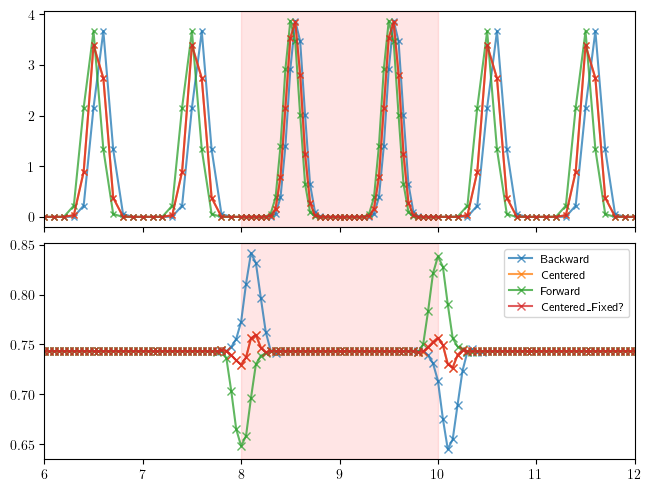

In [64]:
fig, ax = plt.subplots(2,1, sharex=True, constrained_layout=True)

for diff in difference: 
    src = xr.open_zarr(src_fp.format(diff)).compute()
    
    melt_at_ref = src.surf_melt.isel(coord_2=-1, coord_1=175) * (1/dt)
    
    ax[0].plot(melt_at_ref.t, melt_at_ref, alpha=0.75, marker='x', markersize=5.0)
    
    
    
    # if diff == 'Centered': 
    interp = melt_at_ref.interp(t=np.linspace(0.05,16,320), method='quadratic')

    melt_at_ref_interp = interp.rolling(t=20,center=True).mean('t')

    ax[1].plot(melt_at_ref_interp.t, melt_at_ref_interp, alpha=0.75, marker='x', label=diff)
    

plt.xlim(6,12)

ax[1].legend(fontsize='small')

[ax[i].axvspan(8, 10, alpha=0.1, color='r') for i in range(2)]